# Demo for analysis the result

## Plot transform result

> Found 7995 images...


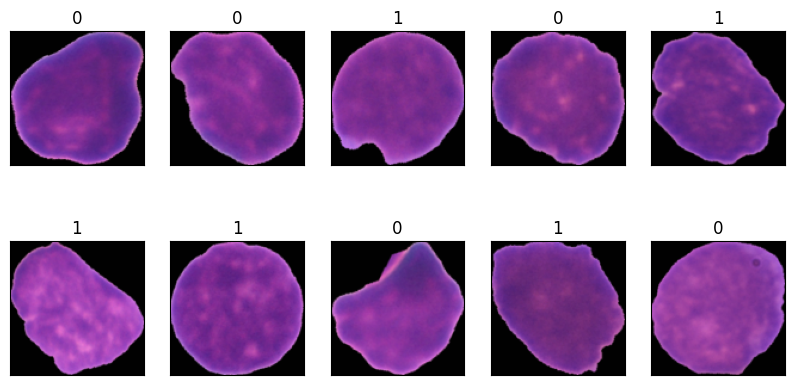

In [1]:
from dataloader import LeukemiaLoader
from ResNet import ResNet18, ResNet50, ResNet152
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_random_10_images():
    train_dataset = LeukemiaLoader(root='/home/linjohnss/NYCU_DL/lab3/dataset', mode='train')
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        # random select an image
        # num = np.random.randint(0, len(train_dataset))
        image, label = train_dataset[i]
        # convert to image
        image = (image * 255).to(torch.uint8)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(label)
        plt.xticks([])
        plt.yticks([])
    plt.savefig("./random_10_images.png")
    # plt.close()

def main():
    plot_random_10_images()

    
    
        
if __name__ == "__main__":    
    main()


## Using WeightedRandomSampler balance the dataset

In [2]:
# calculate the training dataset label ratio
train_dataset = LeukemiaLoader(root='/home/linjohnss/NYCU_DL/lab3/dataset', mode='valid')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12)
train_label = []
for _, label in train_loader:
    train_label.append(label)
train_label = torch.cat(train_label, dim=0)
train_label = train_label.cpu().numpy()
print("train label ratio: ", np.bincount(train_label) / len(train_label))


> Found 1599 images...
train label ratio:  [0.31769856 0.68230144]


In [3]:
from torch.utils.data.sampler import WeightedRandomSampler
from dataloader import LeukemiaLoader

def get_weighted_sampler(train_dataset):
    target = np.array(train_dataset.label)
    class_sample_count = np.unique(target, return_counts=True)[1]
    print("class_sample_count: ", class_sample_count)
    weights = 1. / torch.Tensor(class_sample_count)
    samples_weight = weights[target]
    sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(target), replacement=True)
    return sampler
train_dataset = LeukemiaLoader(root='/home/linjohnss/NYCU_DL/lab3/dataset', mode='train')
valid_dataset = LeukemiaLoader(root='/home/linjohnss/NYCU_DL/lab3/dataset', mode='valid')
# use weughtrandomsampler to balance the dataset
sampler = get_weighted_sampler(train_dataset)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, sampler=sampler, num_workers=12)

> Found 7995 images...
> Found 1599 images...
class_sample_count:  [2542 5453]


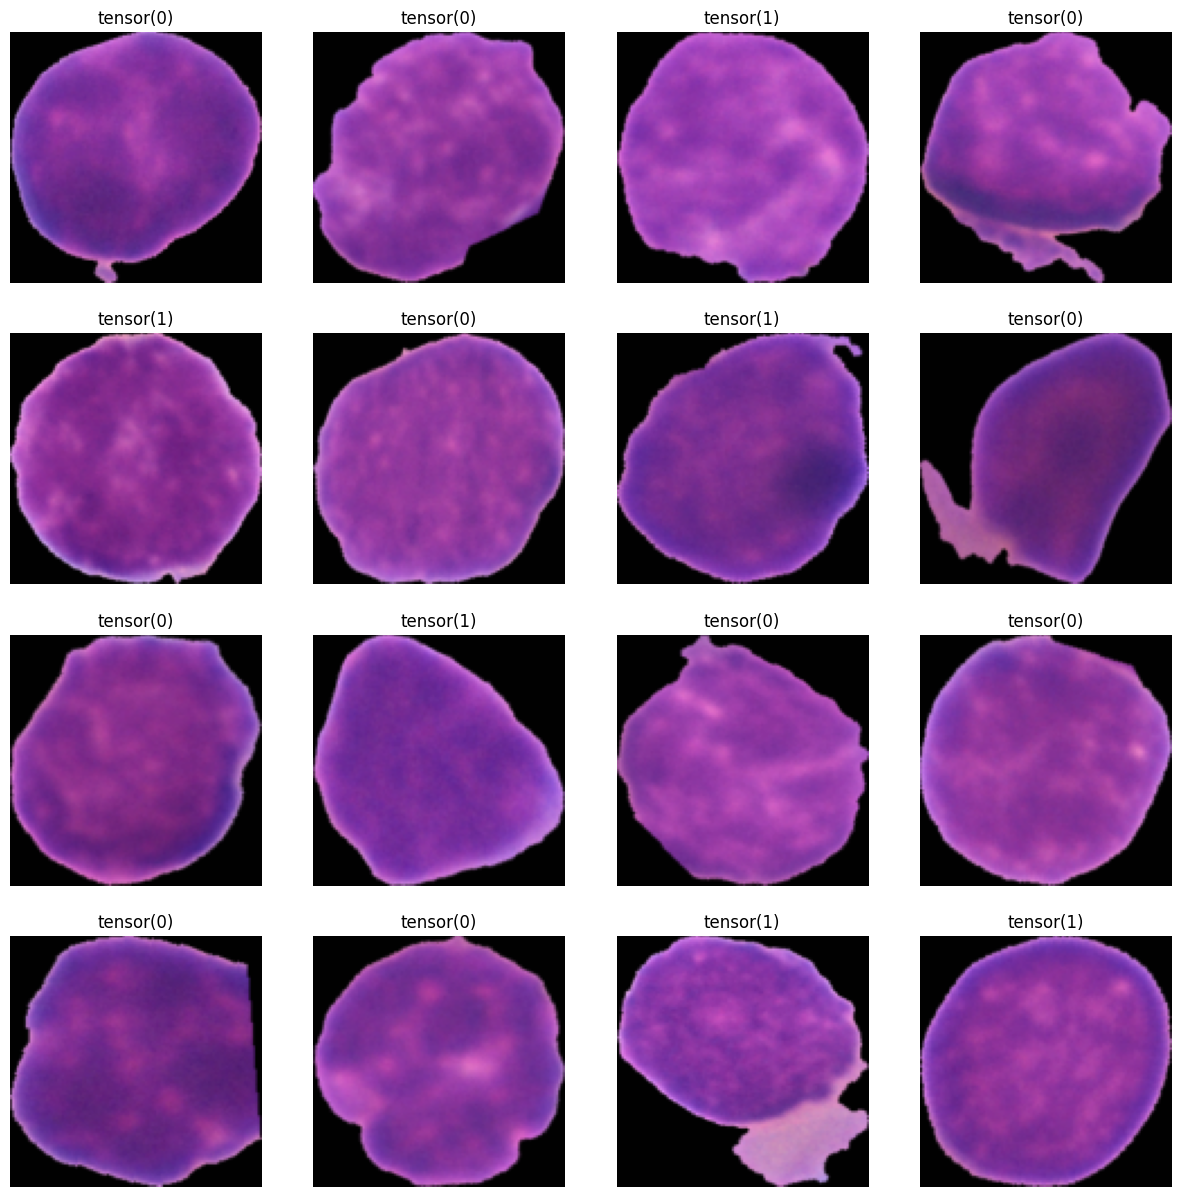

In [4]:
# plot a batch of train_loader images (batch_size=32)
for i, (images, labels) in enumerate(train_loader):
    plt.figure(figsize=(15, 15))
    for j in range(16):
        plt.subplot(4, 4, j + 1)
        image = (images[j] * 255).to(torch.uint8)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(labels[j])
        plt.axis('off')
    break

## plot train hsitory with each model

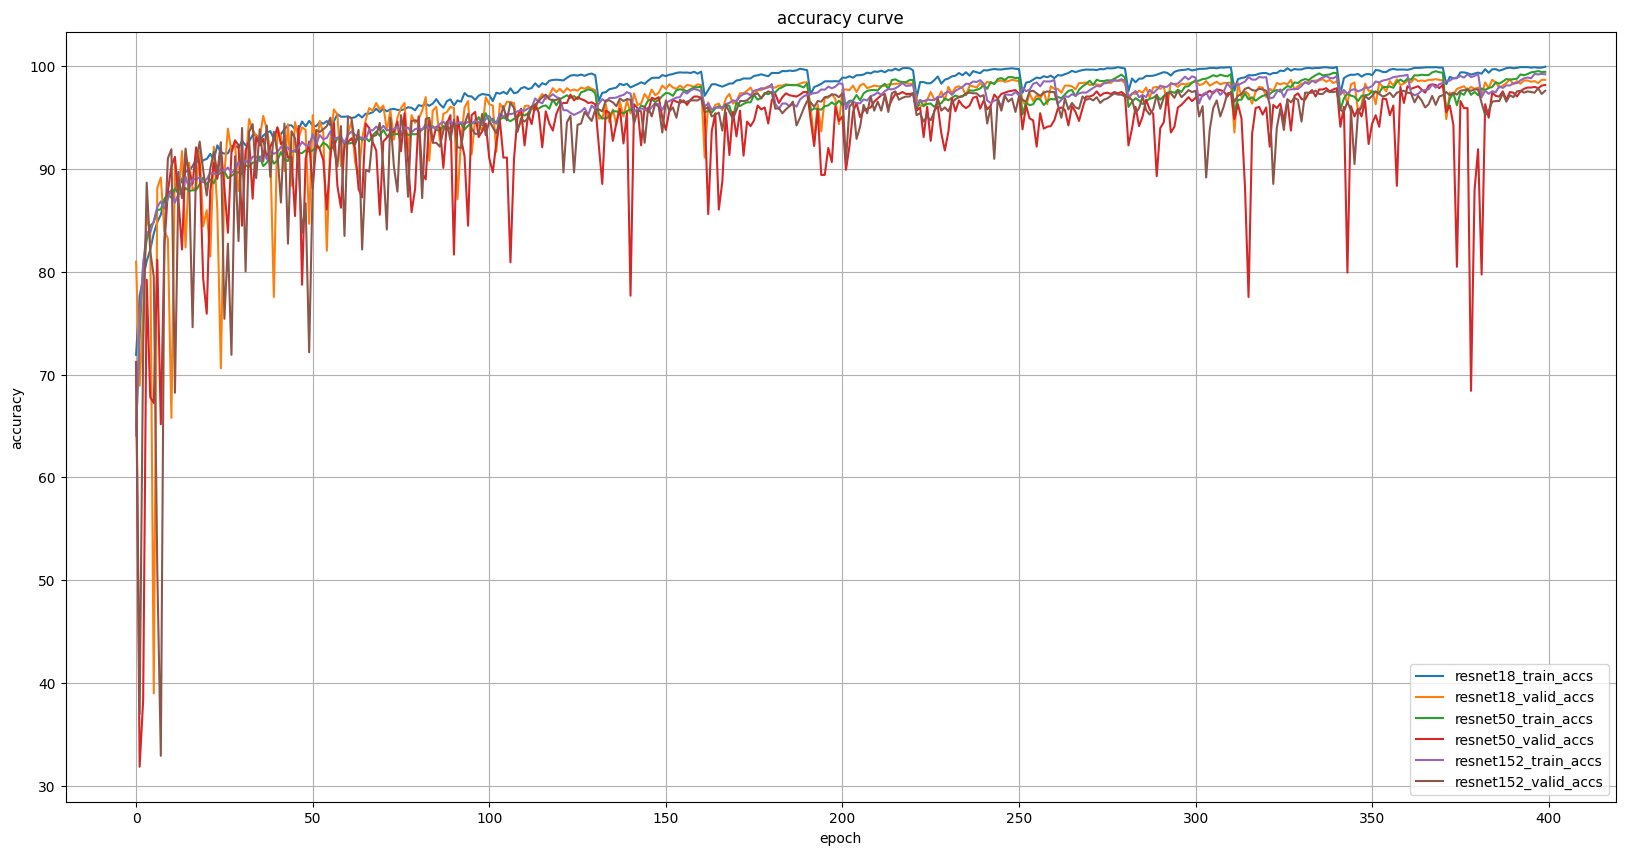

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data_path = "/home/linjohnss/NYCU_DL/lab3"
resnet18_accs = pd.read_csv(data_path + "/resnet18_accs.csv")
resnet50_accs = pd.read_csv(data_path + "/resnet50_accs.csv")
resnet152_accs = pd.read_csv(data_path + "/resnet152_accs.csv")
plt.figure(figsize=(20, 10))
plt.plot(resnet18_accs['epoch'], resnet18_accs['train_accs'], label='resnet18_train_accs')
plt.plot(resnet18_accs['epoch'], resnet18_accs['valid_accs'], label='resnet18_valid_accs')
plt.plot(resnet50_accs['epoch'], resnet50_accs['train_accs'], label='resnet50_train_accs')
plt.plot(resnet50_accs['epoch'], resnet50_accs['valid_accs'], label='resnet50_valid_accs')
plt.plot(resnet152_accs['epoch'], resnet152_accs['train_accs'], label='resnet152_train_accs')
plt.plot(resnet152_accs['epoch'], resnet152_accs['valid_accs'], label='resnet152_valid_accs')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.grid()
plt.title("accuracy curve")
plt.savefig("./resnet18_50_152_accs.png")

## plot confusion matrix

In [6]:
def plot_confusion_matrix(y_true, y_pred, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, square=True, cmap=cmap)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title + " confusion matrix")


> Found 1599 images...
valid accuracy:  0.9856160100062539


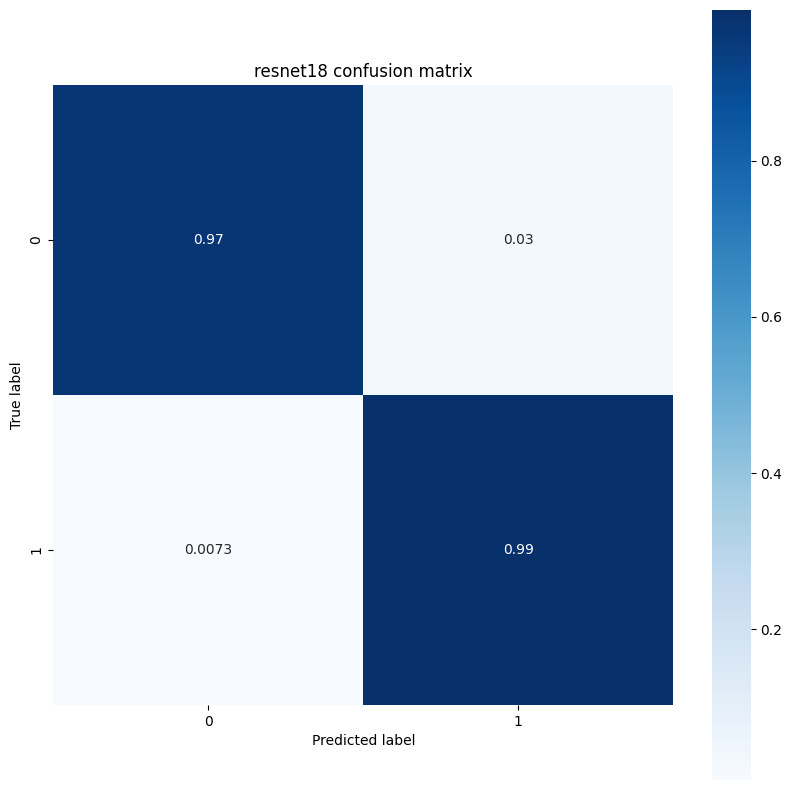

In [10]:
# plot confusion matrix
model_type = "resnet18"
valid_dataset = LeukemiaLoader(root='/home/linjohnss/NYCU_DL/lab3/dataset', mode='valid')
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=12)
device = torch.device("cuda:" + str(0) if torch.cuda.is_available() else "cpu")
if model_type == "resnet18":
    model = ResNet18().to(device)
elif model_type == "resnet50":
    model = ResNet50().to(device)
elif model_type == "resnet152":
    model = ResNet152().to(device)
else:
    raise ValueError("Invalid model name")
model.load_state_dict(torch.load("./" + model_type + "_best_model.pth"))
model.eval()
predict_result = []
ground_truth = []
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.long)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        predict_result.append(predicted)
        ground_truth.append(labels)
predict_result = torch.cat(predict_result, dim=0)
ground_truth = torch.cat(ground_truth, dim=0)
predict_result = predict_result.cpu().numpy()
ground_truth = ground_truth.cpu().numpy()
plot_confusion_matrix(ground_truth, predict_result, title=model_type)
print("valid accuracy: ", (predict_result == ground_truth).sum() / len(predict_result))

> Found 1599 images...
valid accuracy:  0.9824890556597874


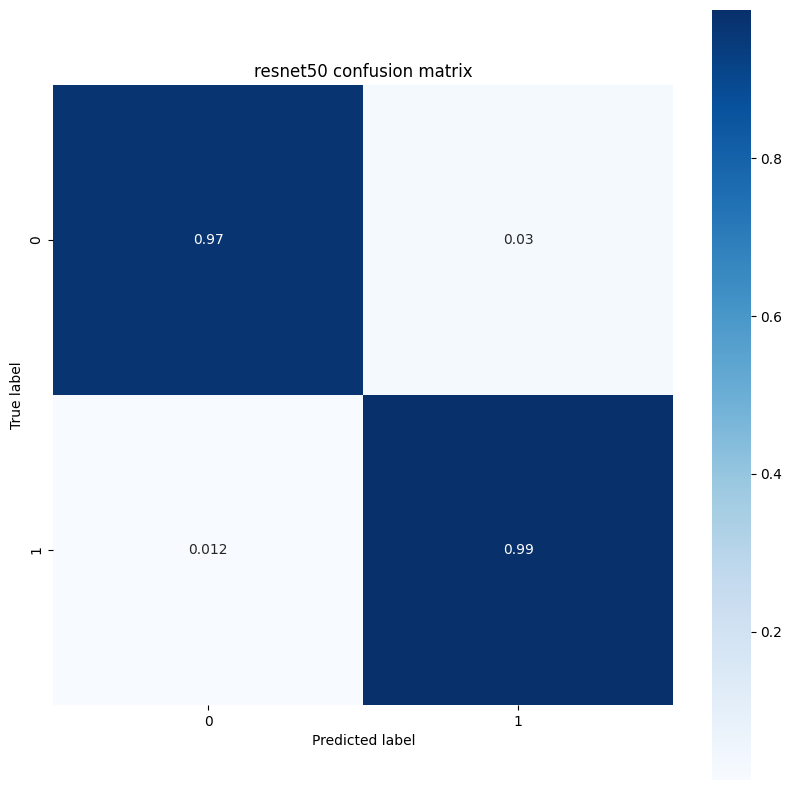

In [12]:
# plot confusion matrix
model_type = "resnet50"
valid_dataset = LeukemiaLoader(root='/home/linjohnss/NYCU_DL/lab3/dataset', mode='valid')
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=12)
device = torch.device("cuda:" + str(0) if torch.cuda.is_available() else "cpu")
if model_type == "resnet18":
    model = ResNet18().to(device)
elif model_type == "resnet50":
    model = ResNet50().to(device)
elif model_type == "resnet152":
    model = ResNet152().to(device)
else:
    raise ValueError("Invalid model name")
model.load_state_dict(torch.load("./" + model_type + "_best_model.pth"))
model.eval()
predict_result = []
ground_truth = []
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.long)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        predict_result.append(predicted)
        ground_truth.append(labels)
predict_result = torch.cat(predict_result, dim=0)
ground_truth = torch.cat(ground_truth, dim=0)
predict_result = predict_result.cpu().numpy()
ground_truth = ground_truth.cpu().numpy()
plot_confusion_matrix(ground_truth, predict_result, title=model_type)
print("valid accuracy: ", (predict_result == ground_truth).sum() / len(predict_result))

> Found 1599 images...
valid accuracy:  0.9793621013133208


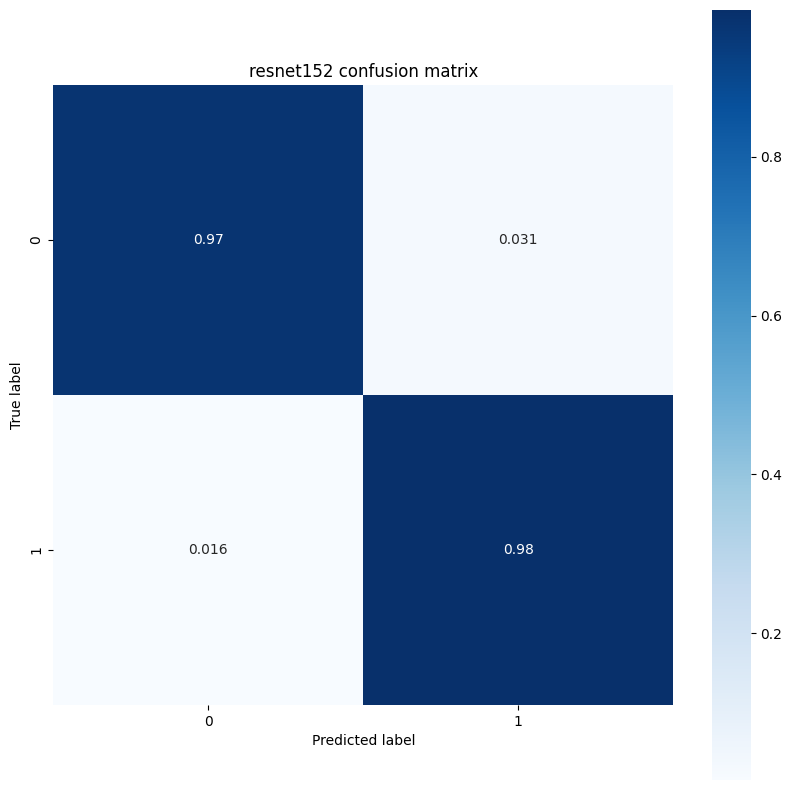

In [11]:
# plot confusion matrix
model_type = "resnet152"
valid_dataset = LeukemiaLoader(root='/home/linjohnss/NYCU_DL/lab3/dataset', mode='valid')
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=12)
device = torch.device("cuda:" + str(0) if torch.cuda.is_available() else "cpu")
if model_type == "resnet18":
    model = ResNet18().to(device)
elif model_type == "resnet50":
    model = ResNet50().to(device)
elif model_type == "resnet152":
    model = ResNet152().to(device)
else:
    raise ValueError("Invalid model name")
model.load_state_dict(torch.load("./" + model_type + "_best_model.pth"))
model.eval()
predict_result = []
ground_truth = []
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.long)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        predict_result.append(predicted)
        ground_truth.append(labels)
predict_result = torch.cat(predict_result, dim=0)
ground_truth = torch.cat(ground_truth, dim=0)
predict_result = predict_result.cpu().numpy()
ground_truth = ground_truth.cpu().numpy()
plot_confusion_matrix(ground_truth, predict_result, title=model_type)
print("valid accuracy: ", (predict_result == ground_truth).sum() / len(predict_result))